In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## Count how many people survived and how many died

In [6]:
survived = train_df[train_df['Survived'] == 1]
died = train_df[train_df['Survived'] == 0]
print('Survived: %i (%.1f%%)' % (len(survived), float(len(survived))/len(train_df)*100.0))
print('Died: %i (%.1f%%)' % (len(died), float(len(died))/len(train_df)*100.0))

Survived: 342 (38.4%)
Died: 549 (61.6%)


In [7]:
# Extact the title from the name
train_df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_df['Title'] = test_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Extract Last Name
train_df['LastName'] = train_df['Name'].apply(lambda x: str.split(x, ",")[0])
test_df['LastName'] = test_df['Name'].apply(lambda x: str.split(x, ",")[0])

# Temporarily combine both datasets and extract the family size
full_df = pd.concat([train_df, test_df])
full_df['FamilySize'] = full_df['SibSp'] + full_df['Parch'] + 1

# Get the family size from the last name
full_df['FamilySizeFromName'] = full_df.groupby('LastName')['LastName'].transform('count')

# Get the family size from the ticket
full_df['FamilySizeFromTicket'] = full_df.groupby('Ticket')['Ticket'].transform('count')

# Get the family size from the cabin
full_df['FamilySizeFromCabin'] = full_df.groupby('Cabin')['Cabin'].transform('count')

# Split back into train and test
train_df = full_df[:len(train_df)]
test_df = full_df[len(train_df):]

train_df = train_df.drop(['Name'], axis=1)
train_df = train_df.drop(["LastName"], axis=1)

test_df = test_df.drop(['Name'], axis=1)
test_df = test_df.drop(["LastName"], axis=1)


# Combine Miss and Mlle titles
train_df['Title'] = train_df['Title'].replace(['Mlle', 'Ms'], 'Miss')
test_df['Title'] = test_df['Title'].replace(['Mlle', 'Ms'], 'Miss')

# Combine Mme and Mrs titles
train_df['Title'] = train_df['Title'].replace(['Mme'], 'Mrs')
test_df['Title'] = test_df['Title'].replace(['Mme'], 'Mrs')

# Combine Dr, Rev, Col, Major, Capt titles
train_df['Title'] = train_df['Title'].replace(['Dr', 'Rev', 'Col', 'Major', 'Capt'], 'Officer')
test_df['Title'] = test_df['Title'].replace(['Dr', 'Rev', 'Col', 'Major', 'Capt'], 'Officer')

# Combine Don, Sir, the Countess, Lady, Dona titles
train_df['Title'] = train_df['Title'].replace(['Don', 'Sir', 'the Countess', 'Lady', 'Dona'], 'Royalty')
test_df['Title'] = test_df['Title'].replace(['Don', 'Sir', 'the Countess', 'Lady', 'Dona'], 'Royalty')

# Combine Jonkheer and Master titles
train_df['Title'] = train_df['Title'].replace(['Jonkheer'], 'Master')
test_df['Title'] = test_df['Title'].replace(['Jonkheer'], 'Master')

# Fill NA titles with 'NoTitle'
train_df['Title'] = train_df['Title'].fillna('NoTitle')

title_encoder = LabelEncoder()
train_df['Title'] = title_encoder.fit_transform(train_df['Title'])
test_df['Title'] = title_encoder.transform(test_df['Title'])


In [8]:
train_df["HasCabin"] = (train_df["Cabin"].notnull().astype('int'))
train_df["CabinNumber"] = train_df["Cabin"].str.extract('([0-9]+)', expand=False)
train_df["Deck"] = train_df["Cabin"].str.extract('([A-Z]+)', expand=False)
train_df = train_df.drop(['Cabin'], axis=1)

test_df["HasCabin"] = (test_df["Cabin"].notnull().astype('int'))
test_df["CabinNumber"] = test_df["Cabin"].str.extract('([0-9]+)', expand=False)
test_df["Deck"] = test_df["Cabin"].str.extract('([A-Z]+)', expand=False)
test_df = test_df.drop(['Cabin'], axis=1)

train_df['Deck'] = train_df['Deck'].fillna('Z')
test_df['Deck'] = test_df['Deck'].fillna('Z')

deck_encoder = LabelEncoder()
train_df['Deck'] = deck_encoder.fit_transform(train_df['Deck'])
test_df['Deck'] = deck_encoder.transform(test_df['Deck'])

In [9]:
train_df["TicketPrefix"] = train_df["Ticket"].str.extract('([A-Za-z\.\/]+)', expand=False)
train_df["TicketNumber"] = train_df["Ticket"].str.extract('([0-9]+)', expand=False)
train_df = train_df.drop(['Ticket'], axis=1)

test_df["TicketPrefix"] = test_df["Ticket"].str.extract('([A-Za-z\.\/]+)', expand=False)
test_df["TicketNumber"] = test_df["Ticket"].str.extract('([0-9]+)', expand=False)
test_df = test_df.drop(['Ticket'], axis=1)

train_df['TicketPrefix'] = train_df['TicketPrefix'].fillna('Z')



# Encode the TicketPrefix, ignoring unseen prefixes
prefix_encoder = LabelEncoder()
train_df['TicketPrefix'] = prefix_encoder.fit_transform(train_df['TicketPrefix'])

# For the test data, fill both NA values with null, as well as any values we haven't seen before
test_df['TicketPrefix'] = test_df['TicketPrefix'].fillna('Z')
test_df.loc[~test_df['TicketPrefix'].isin(prefix_encoder.classes_), 'TicketPrefix'] = 'Z'

test_df['TicketPrefix'] = prefix_encoder.transform(test_df['TicketPrefix'])

train_df['TicketNumber'] = train_df['TicketNumber'].fillna(0)
test_df['TicketNumber'] = test_df['TicketNumber'].fillna(0)

# Convert the ticket number to an integer
train_df['TicketNumber'] = train_df['TicketNumber'].astype('int')
test_df['TicketNumber'] = test_df['TicketNumber'].astype('int')

In [10]:
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].median())
test_df['Age'] = test_df['Age'].fillna(test_df['Age'].median())

train_df['Embarked'] = train_df['Embarked'].fillna('S')
test_df['Embarked'] = test_df['Embarked'].fillna('S')

train_df['Fare'] = train_df['Fare'].fillna(train_df['Fare'].median())
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].median())

train_df['FamilySizeFromCabin'] = train_df['FamilySizeFromCabin'].fillna(train_df['FamilySizeFromCabin'].median())
test_df['FamilySizeFromCabin'] = test_df['FamilySizeFromCabin'].fillna(test_df['FamilySizeFromCabin'].median())

train_df['CabinNumber'] = train_df['CabinNumber'].fillna(train_df['CabinNumber'].median())
test_df['CabinNumber'] = test_df['CabinNumber'].fillna(test_df['CabinNumber'].median())

In [11]:
embarked_encoder = LabelEncoder()
train_df['Embarked'] = embarked_encoder.fit_transform(train_df['Embarked'])
test_df['Embarked'] = embarked_encoder.transform(test_df['Embarked'])

sex_encoder = LabelEncoder()
train_df['Sex'] = sex_encoder.fit_transform(train_df['Sex'])
test_df['Sex'] = sex_encoder.transform(test_df['Sex'])

In [12]:
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,FamilySizeFromName,FamilySizeFromTicket,FamilySizeFromCabin,HasCabin,CabinNumber,Deck,TicketPrefix,TicketNumber
0,1,0.0,3,1,22.0,1,0,7.2500,2,3,2,2,1,2.0,0,43.0,8,3,5
1,2,1.0,1,0,38.0,1,0,71.2833,0,4,2,2,2,2.0,1,85,2,15,17599
2,3,1.0,3,0,26.0,0,0,7.9250,2,2,1,1,1,2.0,0,43.0,8,33,2
3,4,1.0,1,0,35.0,1,0,53.1000,2,4,2,2,2,2.0,1,123,2,39,113803
4,5,0.0,3,1,35.0,0,0,8.0500,2,3,1,2,1,2.0,0,43.0,8,39,373450


In [13]:
train_df.isna().sum()

PassengerId             0
Survived                0
Pclass                  0
Sex                     0
Age                     0
SibSp                   0
Parch                   0
Fare                    0
Embarked                0
Title                   0
FamilySize              0
FamilySizeFromName      0
FamilySizeFromTicket    0
FamilySizeFromCabin     0
HasCabin                0
CabinNumber             0
Deck                    0
TicketPrefix            0
TicketNumber            0
dtype: int64

In [14]:
train_df = train_df.drop(['PassengerId'], axis=1)

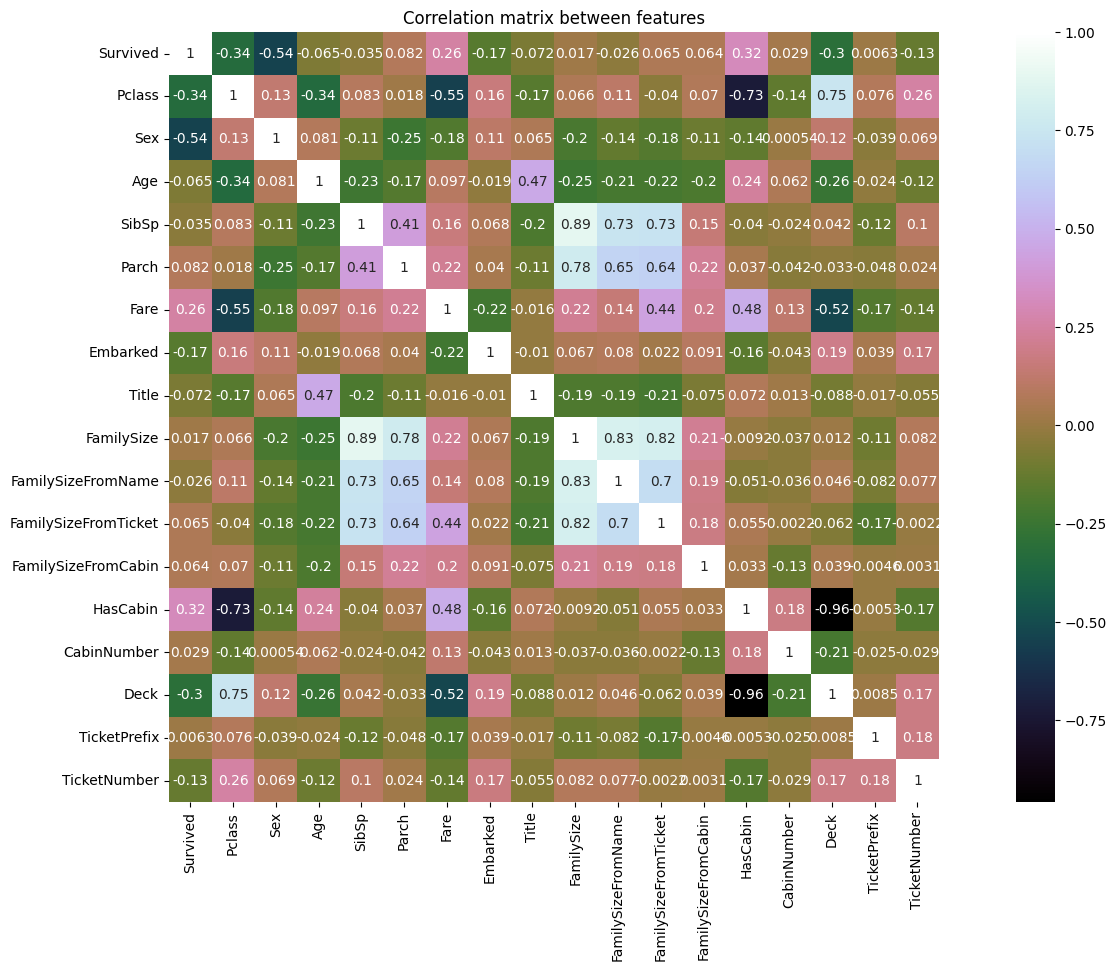

In [15]:
correlation_matrix = train_df.corr()
plt.figure(figsize=(20,10))
sns.heatmap(correlation_matrix, vmax=1, square=True, annot=True, cmap='cubehelix')
plt.title('Correlation matrix between features')
plt.show()

In [16]:
train_df = train_df.drop(['SibSp'], axis=1)
train_df = train_df.drop(['Parch'], axis=1)
train_df = train_df.drop(['Title'], axis=1)
train_df = train_df.drop(['Age'], axis=1)
train_df = train_df.drop(['FamilySize'], axis=1)
train_df = train_df.drop(['FamilySizeFromTicket'], axis=1)
train_df = train_df.drop(['FamilySizeFromName'], axis=1)
train_df = train_df.drop(['FamilySizeFromCabin'], axis=1)
train_df = train_df.drop(['TicketPrefix'], axis=1)
train_df = train_df.drop(['CabinNumber'], axis=1)

test_df = test_df.drop(['SibSp'], axis=1)
test_df = test_df.drop(['Parch'], axis=1)
test_df = test_df.drop(['Title'], axis=1)
test_df = test_df.drop(['Age'], axis=1)
test_df = test_df.drop(['FamilySize'], axis=1)
test_df = test_df.drop(['FamilySizeFromTicket'], axis=1)
test_df = test_df.drop(['FamilySizeFromName'], axis=1)
test_df = test_df.drop(['FamilySizeFromCabin'], axis=1)
test_df = test_df.drop(['TicketPrefix'], axis=1)
test_df = test_df.drop(['CabinNumber'], axis=1)

test_df_ids = test_df['PassengerId']
test_df = test_df.drop(['PassengerId'], axis=1)

train_df.head()

,Survived,Pclass,Sex,Fare,Embarked,HasCabin,Deck
0,0.0,3,1,7.2500,2,0,8
1,1.0,1,0,71.2833,0,1,2
2,1.0,3,0,7.9250,2,0,8
3,1.0,1,0,53.1000,2,1,2
4,0.0,3,1,8.0500,2,0,8


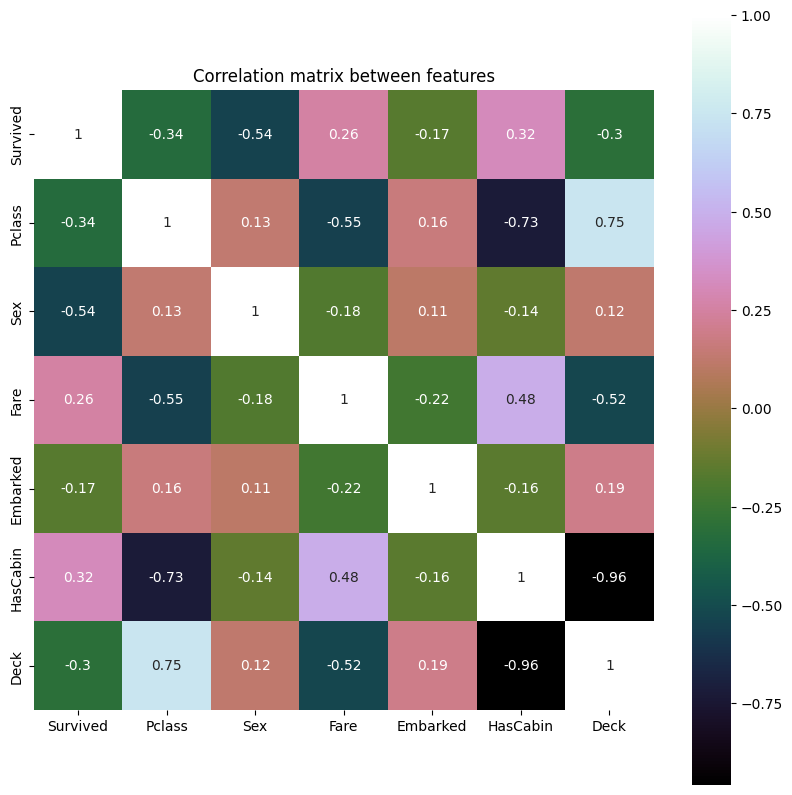

In [17]:
correlation_matrix = train_df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation_matrix, vmax=1, square=True, annot=True, cmap='cubehelix')
plt.title('Correlation matrix between features')
plt.show()

In [18]:
test_df = test_df.drop(['Survived'], axis=1)
test_df.head()

train_y = train_df['Survived']
train_X = train_df.drop(['Survived'], axis=1)

In [19]:
scaler = StandardScaler()
train_df = scaler.fit_transform(train_X)
test_df = scaler.transform(test_df)

In [20]:
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
model.fit(train_X, train_y)

rf_predictions = model.predict(test_df)

/home/chase/.virtualenvs/ml/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [21]:
model = XGBClassifier(n_estimators=100, max_depth=5, random_state=42)
model.fit(train_X, train_y)

xgb_predictions = model.predict(test_df)

/home/chase/.virtualenvs/ml/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/chase/.virtualenvs/ml/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/chase/.virtualenvs/ml/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/chase/.virtualenvs/ml/lib/python3.10/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int

In [22]:
model = LGBMClassifier(n_estimators=100, max_depth=5, random_state=42)
model.fit(train_X, train_y)

lgb_predictions = model.predict(test_df)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 152
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

In [23]:
# Average the predictions
predictions = (rf_predictions + xgb_predictions + lgb_predictions) / 3

# Round to 0 or 1
predictions = np.round(predictions).astype(int)

# Create submission DataFrame
submission_df = pd.DataFrame(columns=['PassengerId', 'Survived'])

# Populate the passenger ID columns
submission_df['PassengerId'] = test_df_ids
submission_df['Survived'] = predictions

# Output CSV file
print("Saving submission...")
submission_df.to_csv('data/submission.csv', index=False)
submission_df.head()

Saving submission...


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [24]:
survived = submission_df[submission_df['Survived'] == 1]
died = submission_df[submission_df['Survived'] == 0]
print('Survived: %i (%.1f%%)' % (len(survived), float(len(survived))/len(submission_df)*100.0))
print('Died: %i (%.1f%%)' % (len(died), float(len(died))/len(submission_df)*100.0))

Survived: 152 (36.4%)
Died: 266 (63.6%)
